In [2]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math


In [3]:
%matplotlib inline

In [4]:
m = n = l = 4 # L of square grid

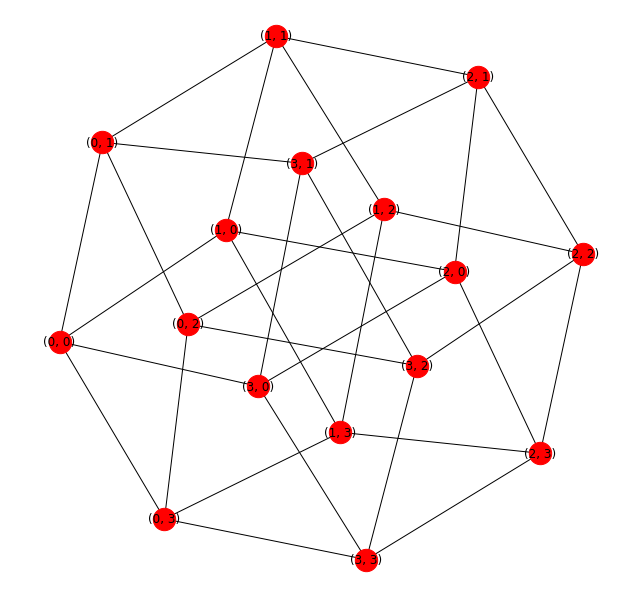

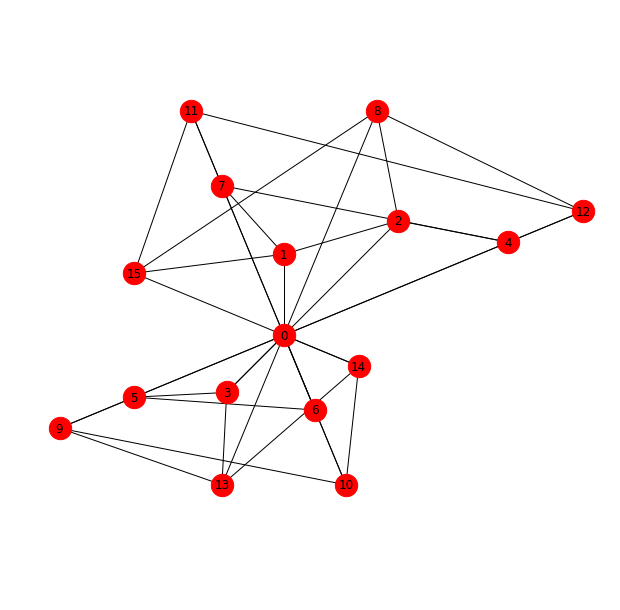

In [20]:
import imp 

import graph_gen
imp.reload(graph_gen)

periodic = True
N, J_interaction = graph_gen.grid_2d_interaction(n,m, periodic=periodic)

H = np.random.random(N)
#H=np.zeros(N)

num_swap = 1
swaps = [[0,2], [1,3], [12,8]]
J_interaction_rand = J_interaction.copy()
H_rand = H.copy()

for w in swaps:
    rev = list(reversed(w))
    J_interaction_rand[w] = J_interaction_rand[rev] 
    J_interaction_rand[:,w] = J_interaction_rand[:,rev] 
    H_rand[w] = H_rand[rev]
    
graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(1e-6,1.1,1e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [21]:
import model
import imp
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

fe_ex = []
ener_ex = []
m_ex = []
m_i_ex = []
for beta in betas_fast:
    tree.exact(beta)
    fe_ex.append(tree.free_energy)
    ener_ex.append(tree.E_mean)
    m_ex.append(tree.M_mean)
    m_i_ex.append(tree.M_i_mean)

beta: 0.0, Fe: -693147.181 Energy: -2.34e-06 M: 4.91e-07 S: 0.693
beta: 0.1, Fe: -7.056 Energy: -0.261 M: 0.0765 S: 0.68
beta: 0.2, Fe: -3.752 Energy: -0.679 M: 0.262 S: 0.615
beta: 0.3, Fe: -2.846 Energy: -1.44 M: 0.617 S: 0.422
beta: 0.4, Fe: -2.586 Energy: -2.1 M: 0.881 S: 0.195
beta: 0.5, Fe: -2.519 Energy: -2.35 M: 0.964 S: 0.0821
beta: 0.6, Fe: -2.500 Energy: -2.44 M: 0.988 S: 0.0357
beta: 0.7, Fe: -2.494 Energy: -2.47 M: 0.995 S: 0.0159
beta: 0.8, Fe: -2.492 Energy: -2.48 M: 0.998 S: 0.00718
beta: 0.9, Fe: -2.491 Energy: -2.49 M: 0.999 S: 0.00326
beta: 1.0, Fe: -2.491 Energy: -2.49 M: 1.0 S: 0.00148


In [22]:
import imp
import bp_nn
imp.reload(bp_nn)

fe_nn = []
ener_nn = []
m_nn = []
m_i_nn = []
net = bp_nn.bp_nn(N, tree, True, z2=False, 
                x_hat_clip=True )

for beta in betas_fast:
    
    net.train(beta = beta, lr=0.005, max_step=1000, 
              batch_size=1000,
             opt = "adam")
    
    net.compute_stat(beta, batch_size = 100000)
    fe_nn.append(net.F)
    ener_nn.append(net.E)
    m_nn.append(net.M)
    m_i_nn.append(net.M_i)


 0.00 1000 fe: -693147.172 +- 0.05386 E: 0.003, S: 0.693, M: -0.00437, W: 2.01295e-06, -0.0, Bias: 0.000002 - 0.000001
 0.10 1000 fe: -7.055 +- 0.03107 E: -0.273, S: 0.678, M: 0.0841, W: 0.206581, -0.0, Bias: 0.231199 - 0.135658
 0.20 1000 fe: -3.743 +- 0.05876 E: -0.675, S: 0.613, M: 0.272, W: 0.462468, -0.0, Bias: 0.693783 - 0.428102
 0.30 1000 fe: -2.837 +- 0.05313 E: -1.444, S: 0.418, M: 0.647, W: 0.76373, -0.0, Bias: 1.750612 - 1.119686
 0.40 1000 fe: -2.585 +- 0.02265 E: -2.133, S: 0.181, M: 0.902, W: 0.953911, -0.0, Bias: 3.187917 - 2.132508
 0.50 1000 fe: -2.519 +- 0.01462 E: -2.351, S: 0.084, M: 0.964, W: 1.17461, -0.0, Bias: 4.485533 - 3.014824
 0.60 1000 fe: -2.499 +- 0.00149 E: -2.437, S: 0.037, M: 0.987, W: 1.41986, -0.0, Bias: 5.644099 - 3.793385
 0.70 1000 fe: -2.494 +- 0.00112 E: -2.473, S: 0.015, M: 0.996, W: 1.67796, -0.0, Bias: 6.739975 - 4.507587
 0.80 257 fe: -2.492 +- 0.00010 E: -2.487, S: 0.004, M: 0.999, W: 2.05845, -0.0, Bias: 7.361304 - 5.030139
 0.90 147 fe: 

import imp
import bp_nn
imp.reload(bp_nn)

fe_nn_rand = []
ener_nn_rand = []
m_nn_rand = []
m_i_nn_rand = []


net_rand = bp_nn.bp_nn(N, tree_rand, True, z2=False)

for beta in betas_fast:
    net_rand.train(beta = beta, opt = "adam",  lr=0.005 ,
                   max_step=1000, batch_size=1000)
    net_rand.compute_stat(beta, batch_size = 100000)
    fe_nn_rand.append(net_rand.F)
    ener_nn_rand.append(net_rand.E)
    m_nn_rand.append(net_rand.M)
    m_i_nn_rand.append(net_rand.M_i)


In [40]:
import bp_solver
imp.reload(bp_solver)

fe_bp = []
ener_bp = []
m_bp = []
m_i_bp = []
BP_tree = bp_solver.BP_solver(tree) 

for beta in betas_fast:
    
    BP_tree.converge(beta, error = 1e-6)
    fe_bp.append(BP_tree.F)
    ener_bp.append(BP_tree.E_mean)
    m_bp.append(BP_tree.M_mean)
    m_i_bp.append(BP_tree.M_i)

fe: -693147.181, ener: -0.000, M: 0.000
fe: -7.054, ener: -0.255, M: 0.077
fe: -3.740, ener: -0.641, M: 0.271
fe: -2.832, ener: -1.461, M: 0.670
fe: -2.583, ener: -2.119, M: 0.900
fe: -2.518, ener: -2.358, M: 0.967
fe: -2.500, ener: -2.440, M: 0.988
fe: -2.494, ener: -2.471, M: 0.995
fe: -2.492, ener: -2.483, M: 0.998
fe: -2.491, ener: -2.487, M: 0.999
fe: -2.491, ener: -2.489, M: 1.000


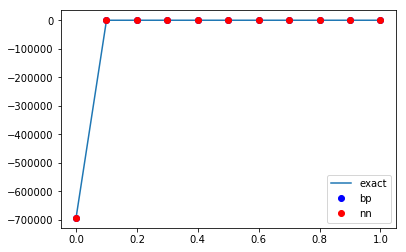

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast
plt.plot(x, fe_ex, label = "exact")
plt.plot(x,fe_bp, "bo", label="bp")
plt.plot(x,fe_nn, "ro", label="nn")
#plt.plot(x,fe_nn_rand, "go", label="bp")
plt.legend()
plt.show()

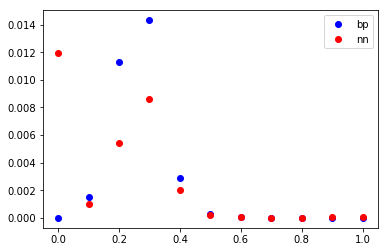

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast
fe_ex = np.array(fe_ex)
fe_bp = np.array(fe_bp)
fe_nn = np.array(fe_nn)
fe_nn_rand = np.array(fe_nn_rand)

plt.plot(x, fe_bp - fe_ex, "bo", label="bp")
plt.plot(x, fe_nn - fe_ex, "ro", label="nn")
#plt.plot(x, fe_nn_rand - fe_ex, "go", label="nn_rand")

plt.legend()
plt.show()

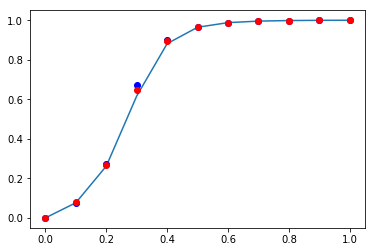

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast
plt.plot(x, m_ex, label = "exact")
plt.plot(x,m_bp, "bo", label="bp")
plt.plot(x,m_nn, "ro", label="nn")
#plt.plot(x,m_nn_rand, "go", label="nn")
plt.legend
plt.show()

In [38]:
m_ex

array([4.90507440e-07, 7.65138663e-02, 2.61842898e-01, 6.16529242e-01,
       8.81484181e-01, 9.64275099e-01, 9.87615720e-01, 9.95322098e-01,
       9.98150888e-01, 9.99249866e-01, 9.99690804e-01])

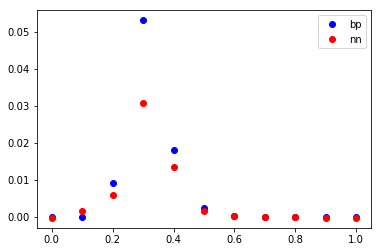

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast

m_ex = np.array(m_ex)
m_bp = np.array(m_bp)
m_nn = np.array(m_nn)
#m_nn_rand = np.array(m_nn_rand)

plt.plot(x, m_bp - m_ex, "bo", label="bp")
plt.plot(x, m_nn - m_ex, "ro", label="nn")
#plt.plot(x, m_nn_rand - m_ex, "go",label = "nn_rand")

plt.legend()
plt.show()

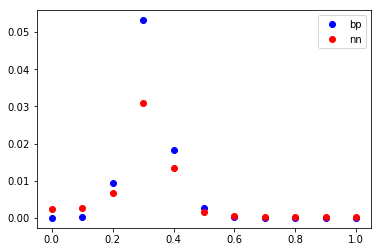

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast

m_i_ex = np.array(m_i_ex)
#m_bp = np.array(m_bp)
m_i_nn = np.array(m_i_nn)
#m_i_nn_rand = np.array(m_i_nn_rand)

plt.plot(x, abs(m_i_bp - m_i_ex).sum(axis=1)/N, "bo", label="bp")
plt.plot(x, abs(m_i_nn - m_i_ex).sum(axis=1)/N, "ro", label="nn")
#plt.plot(x, abs(m_i_nn_rand - m_i_ex).sum(axis=1)/N, "go",label = "nn_rand")

plt.legend()
plt.show()